# Stock price prediction

In this example, we retrieve some historical data for the Berkshire Hathaway stock and provide some forecast for the next few periods(days) on the close price.

In [2]:
import mstarpy as ms
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import itertools


In [3]:
stock = ms.Stock("US0846701086",
                language="en-gb",
                filters={"exchange" : "XNYS"})

In [4]:
import datetime
end_date = datetime.datetime.today()
start_date = end_date - datetime.timedelta(30)

historical_data = stock.historical(start_date, end_date)

In [5]:
import json
with open('historical_brk_data.json', 'w') as f:
    json.dump(historical_data , f)

In [6]:
df = pd.read_json("historical_brk_data.json", convert_dates=['date'])

<Axes: title={'center': 'Berkshire Hathaway Inc Class A'}, xlabel='date'>

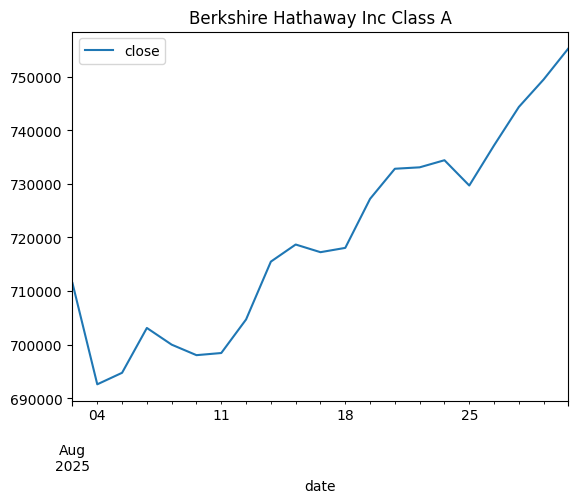

In [7]:
df.plot(x='date', y='close', title=stock.name)

In [8]:
brk_data = df[["close"]]

brk_data.index = df['date']

In [9]:
brk_data.head()

,close
date,
2025-08-01,711480.0
2025-08-04,692600.0
2025-08-05,694750.0
2025-08-06,703115.0
2025-08-07,699999.9


In [10]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(brk_data.close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.969340
p-value: 0.993932


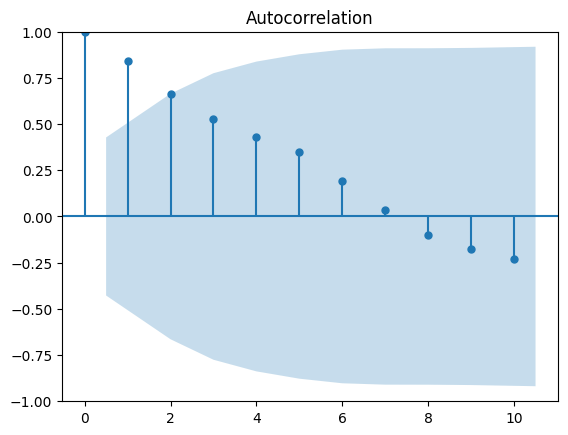

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(brk_data.close)
plt.show()

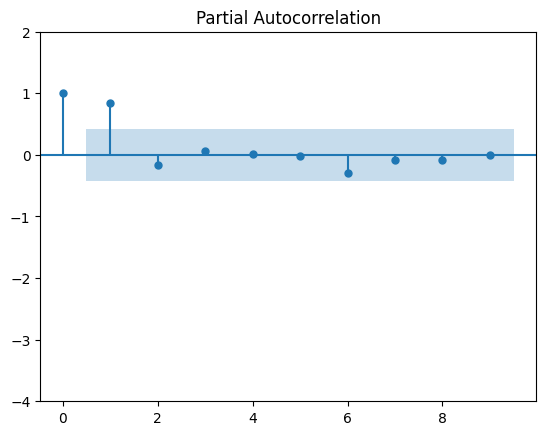

In [12]:
import numpy as np
plot_pacf(brk_data.close,lags=np.arange(10))
plt.ylim([-4,2])
plt.show()

In [13]:

p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

aic_values = []

for order in pdq:
    try:
        model = ARIMA(df['close'], order=order)
        model_fit = model.fit()
        aic_values.append((order, model_fit.aic))
    except:
        continue

results = pd.DataFrame(aic_values, columns=['order','AIC']).sort_values('AIC')
print(results.head())

c:\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting

        order         AIC
15  (1, 2, 0)  386.638485
7   (0, 2, 1)  386.736602
25  (2, 2, 1)  386.753217
24  (2, 2, 0)  387.270911
16  (1, 2, 1)  388.919214


In [14]:
import warnings
warnings.simplefilter('ignore')

In [15]:
brk_data_pred = brk_data.iloc[:-3]

In [16]:
brk_data_pred.tail()

,close
date,
2025-08-20,732814.40625
2025-08-21,733080.00000
2025-08-22,734405.00000
2025-08-25,729686.84375
2025-08-26,737180.00000


In [17]:
brk_data.tail()

,close
date,
2025-08-25,729686.84375
2025-08-26,737180.00000
2025-08-27,744346.53125
2025-08-28,749477.59375
2025-08-29,755280.00000


In [18]:

model = ARIMA(brk_data_pred.close, order=(2,2,2))
model_fit = model.fit()
model_summary = model_fit.summary()
print(model_summary)

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   18
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -168.211
Date:                Mon, 01 Sep 2025   AIC                            346.421
Time:                        10:41:46   BIC                            350.284
Sample:                    08-01-2025   HQIC                           346.619
                         - 08-26-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1141      1.218      0.915      0.360      -1.273       3.501
ar.L2         -0.1316      0.408     -0.323      0.747      -0.931       0.667
ma.L1         -1.1561      1.202     -0.962      0.3

In [19]:
# In-sample predictions
pred = model_fit.get_prediction()
pred_summary = pred.summary_frame(alpha=0.05)

# Out-of-sample forecast (3 steps ahead)
forecast_res = model_fit.get_forecast(steps=3)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()

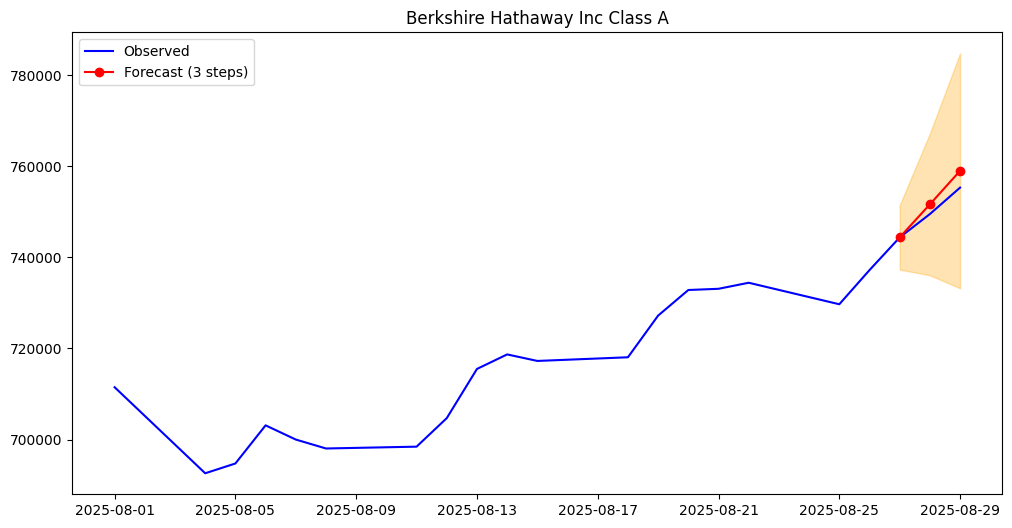

In [20]:
fig, ax = plt.subplots(figsize=(12,6))

# Observed data
ax.plot(df['date'], df['close'], label='Observed', color='blue')

# Forecasted mean
ax.plot(forecast_mean.index, forecast_mean, label='Forecast (3 steps)', color='red', marker='o')

# Forecasted CI
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[:,0],
                forecast_ci.iloc[:,1],
                color='orange', alpha=0.3)

ax.set_title(stock.name)
ax.legend()
plt.show()